# An implementation of Adaptive Bayesian Neural Networks (ABNN) for a basic CNN image classifier on CIFAR-10 dataset

## Import libraries

In [1]:
!pip install netcal
!pip install torchsummary


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.nn.functional import softmax
import torch.nn.functional as F
import netcal.metrics as metrics
from netcal.metrics import ECE
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
from torch.utils.data import random_split
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##  Train the base model and save the weights

### Load and Augment CIFAR-10 and CIFAR100

Similar to the paper, I only use Horizontal Flip for data augmentation

In [4]:
# Define the transform
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_trainset))  # 80% for training
valid_size = len(full_trainset) - train_size  # 20% for validation
train_subset, valid_subset = random_split(full_trainset, [train_size, valid_size])

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_subset, batch_size=128,
                                          shuffle=False, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Verify the sizes of the datasets
print(f'Training set size: {len(train_subset)}')
print(f'Validation set size: {len(valid_subset)}')
print(f'Test set size: {len(testset)}')

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [5]:
# Define the transform
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR100 dataset
full_trainset100 = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                 download=True, transform=transform)

# Split the dataset into training and validation sets
train_size100 = int(0.8 * len(full_trainset100))  # 80% for training
valid_size100 = len(full_trainset100) - train_size100  # 20% for validation
train_subset100, valid_subset100 = random_split(full_trainset100, [train_size100, valid_size100])

# Create DataLoaders
trainloader100 = torch.utils.data.DataLoader(train_subset100, batch_size=128,
                                             shuffle=True, num_workers=2)
validloader100 = torch.utils.data.DataLoader(valid_subset100, batch_size=128,
                                             shuffle=False, num_workers=2)

# Load the test set
testset100 = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
testloader100 = torch.utils.data.DataLoader(testset100, batch_size=128,
                                            shuffle=False, num_workers=2)

# Verify the sizes of the datasets
print(f'Training set size: {len(train_subset100)}')
print(f'Validation set size: {len(valid_subset100)}')
print(f'Test set size: {len(testset100)}')

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


### Define the ResNet50 model

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                epochs: int = 10, learning_rate: float = 0.005, gamma_lr: float = 0.1, 
                milestones: list = [5, 15], save_path: str = 'model.pth',Weight_decay: float = 5e-4) -> (list, list):
    """
    Trains the model and evaluates it on the validation set after each epoch.

    Parameters:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        epochs (int): The number of epochs to train the model.
        learning_rate (float): The learning rate for the optimizer.
        gamma_lr (float): Factor by which the learning rate will be multiplied at each milestone.
        milestones (list): List of epoch indices at which to adjust the learning rate.
        save_path (str): Path to save the trained model state.

    Returns:
        train_losses (tuple): A tuple containing lists of training losses per epoch.
        val_losses (tuple): A tuple containing lists of validation losses per epoch.
    """    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=Weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma_lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Loss calculation
            loss.backward()  # Backward pass (backpropagation)
            optimizer.step()  # Optimize model parameters
            train_loss += loss.item()

        # Store average training loss
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        val_loss = 0.0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

        # Store average validation loss
        val_losses.append(val_loss / len(val_loader))

        # Print epoch summary
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        scheduler.step()  # Adjust learning rate

    # Save the trained model state
    torch.save(model.state_dict(), save_path)

    # Plot training and validation losses
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses


In [7]:
def test_model(model: nn.Module, test_loader: DataLoader, load_path: str = 'vit_mnist.pth') -> None:
    """
    Evaluates the model on the test dataset.

    Parameters:
        model (nn.Module): The neural network model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        load_path (str): Path to the file from which the model state is loaded.
    """
    # Load the saved model state
    model.load_state_dict(torch.load(load_path))
    model.eval()  # Set the model to evaluation mode

    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No gradient calculation for inference
        for data, target in test_loader:
            # Move data and target to the same device as the model
            data, target = data.to(device), target.to(device)

            # Forward pass and loss calculation
            output = model(data)
            test_loss += criterion(output, target).item()

            # Prediction and accuracy calculation
            pred = output.argmax(dim=1, keepdim=True).squeeze()
            correct += pred.eq(target).sum().item()

            # Storing all predictions and targets for F1 score calculation
            all_preds.extend(pred.tolist())
            all_targets.extend(target.tolist())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)

    # Calculate F1 score
    f1 = f1_score(all_targets, all_preds, average='weighted')

    # Print results
    print(f'\n\n Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy}%), F1 Score: {f1:.4f}')


## CIFAR10

In [73]:
net = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
net.to(device)
summary(net, (3, 32, 32))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/home/abduallah_damash/project/ceng502/venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/200, Train Loss: 2.9330, Val Loss: 2.3000
Epoch 2/200, Train Loss: 2.1619, Val Loss: 2.0451
Epoch 3/200, Train Loss: 1.8572, Val Loss: 1.6930
Epoch 4/200, Train Loss: 1.6267, Val Loss: 1.5959
Epoch 5/200, Train Loss: 1.4677, Val Loss: 1.3835
Epoch 6/200, Train Loss: 1.3398, Val Loss: 1.2677
Epoch 7/200, Train Loss: 1.1818, Val Loss: 1.2686
Epoch 8/200, Train Loss: 1.0523, Val Loss: 1.0382
Epoch 9/200, Train Loss: 0.9566, Val Loss: 1.1914
Epoch 10/200, Train Loss: 0.8889, Val Loss: 0.8776
Epoch 11/200, Train Loss: 0.8305, Val Loss: 1.0558
Epoch 12/200, Train Loss: 0.7766, Val Loss: 0.8753
Epoch 13/200, Train Loss: 0.7308, Val Loss: 1.0380
Epoch 14/200, Train Loss: 0.6843, Val Loss: 0.7335
Epoch 15/200, Train Loss: 0.6475, Val Loss: 0.8000
Epoch 16/200, Train Loss: 0.6248, Val Loss: 0.8646
Epoch 17/200, Train Loss: 0.5878, Val Loss: 0.6974
Epoch 18/200, Train Loss: 0.5557, Val Loss: 0.7971
Epoch 19/200, Train Loss: 0.5320, Val Loss: 0.7092
Epoch 20/200, Train Loss: 0.5097, Val Lo

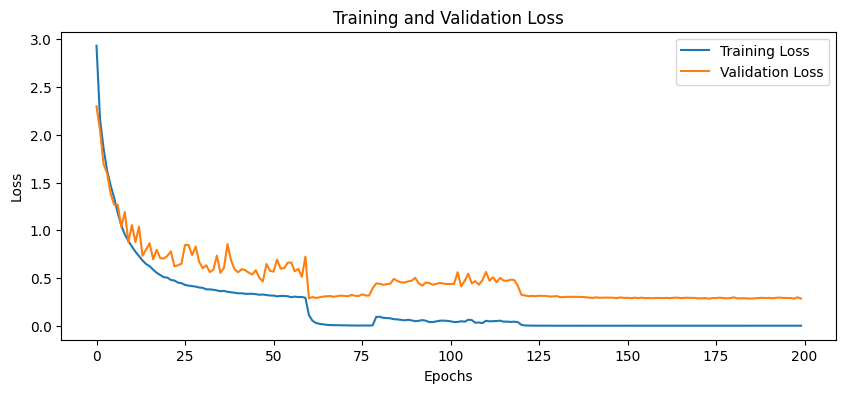



 Test set: Average loss: 0.3174, Accuracy: 9133/10000 (0.9133%), F1 Score: 0.9130


In [50]:
train_losses, val_losses = train_model(net, trainloader, validloader,
                                       epochs=200, learning_rate=0.1, gamma_lr=0.2,
                                       milestones=[60, 120,160], save_path='./net_cifar10.pth', Weight_decay=5e-4)
test_model(net, testloader , load_path="./net_cifar10.pth")

## CIFAR100

In [10]:

net100 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=100)
net100.to(device)
summary(net100, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1, 64,

Epoch 1/200, Train Loss: 1.9202, Val Loss: 2.1812
Epoch 2/200, Train Loss: 1.8123, Val Loss: 2.1609
Epoch 3/200, Train Loss: 1.7178, Val Loss: 2.1533
Epoch 4/200, Train Loss: 1.6349, Val Loss: 2.0209
Epoch 5/200, Train Loss: 1.5642, Val Loss: 1.9290
Epoch 6/200, Train Loss: 1.4969, Val Loss: 2.0346
Epoch 7/200, Train Loss: 1.4278, Val Loss: 2.0160
Epoch 8/200, Train Loss: 1.3751, Val Loss: 1.9552
Epoch 9/200, Train Loss: 1.3263, Val Loss: 2.0651
Epoch 10/200, Train Loss: 1.2793, Val Loss: 1.8537
Epoch 11/200, Train Loss: 1.2354, Val Loss: 2.0147
Epoch 12/200, Train Loss: 1.1964, Val Loss: 1.8804
Epoch 13/200, Train Loss: 1.1611, Val Loss: 1.8958
Epoch 14/200, Train Loss: 1.1292, Val Loss: 1.8894
Epoch 15/200, Train Loss: 1.0955, Val Loss: 1.8371
Epoch 16/200, Train Loss: 1.0610, Val Loss: 1.8674
Epoch 17/200, Train Loss: 1.0344, Val Loss: 1.9268
Epoch 18/200, Train Loss: 1.0241, Val Loss: 1.9577
Epoch 19/200, Train Loss: 0.9946, Val Loss: 1.9169
Epoch 20/200, Train Loss: 0.9591, Val Lo

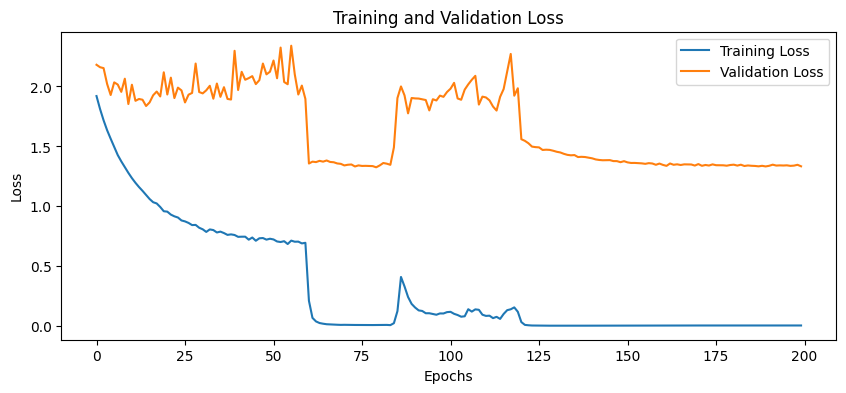

NameError: name 'net' is not defined

In [12]:
torch.backends.cudnn.benchmark = True

train_losses, val_losses = train_model(net100, trainloader100, validloader100,
                                       epochs=200, learning_rate=0.1, gamma_lr=0.2,
                                       milestones=[60, 120,160], save_path='./net_cifar100.pth', Weight_decay=5e-4)


In [13]:

test_model(net100, testloader100 , load_path="./net_cifar100.pth")



 Test set: Average loss: 1.3149, Accuracy: 6677/10000 (0.6677%), F1 Score: 0.6647


In [20]:
"""resnet in pytorch



[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.

    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1
"""

import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3) )
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8          [-1, 256, 32, 32]          16,384
       BatchNorm2d-9          [-1, 256, 32, 32]             512
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
       Bottleneck-12          [-1, 256, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          16,384
      BatchNorm2d-14           [-1, 64,

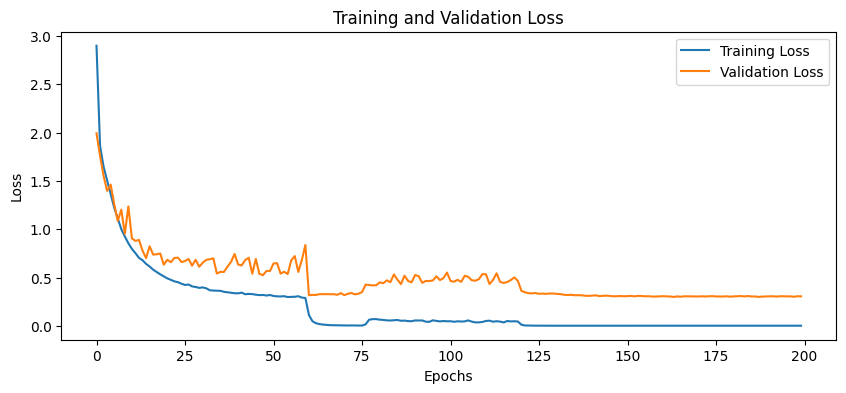



 Test set: Average loss: 0.3174, Accuracy: 9111/10000 (0.9111%), F1 Score: 0.9111
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-1

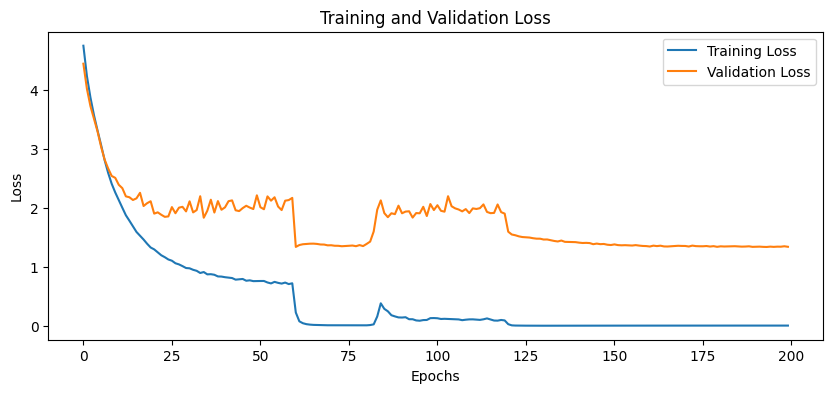



 Test set: Average loss: 1.3107, Accuracy: 6739/10000 (0.6739%), F1 Score: 0.6715


In [17]:
torch.backends.cudnn.benchmark = True
resnet50_cifr10 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
resnet50_cifr10.to(device)
summary(resnet50_cifr10, (3, 32, 32))

train_losses, val_losses = train_model(resnet50_cifr10, trainloader, validloader,
                                       epochs=200, learning_rate=0.1, gamma_lr=0.2,
                                       milestones=[60, 120,160], save_path='./resnet50_cifr10_new_arc_dropout.pth', Weight_decay=5e-4)
test_model(resnet50_cifr10, testloader , load_path="./resnet50_cifr10_new_arc.pth")


resnet50_cifr100 = ResNet(BottleNeck, [3, 4, 6, 3])
resnet50_cifr100.to(device)
summary(resnet50_cifr100, (3, 32, 32))


train_losses, val_losses = train_model(resnet50_cifr100, trainloader100, validloader100,
                                       epochs=200, learning_rate=0.1, gamma_lr=0.2,
                                       milestones=[60, 120,160], save_path='./resnet50_cifr100_new_arc_dropout.pth', Weight_decay=5e-4)


test_model(resnet50_cifr100, testloader100 , load_path="./resnet50_cifr100_new_arc.pth")

In [13]:

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

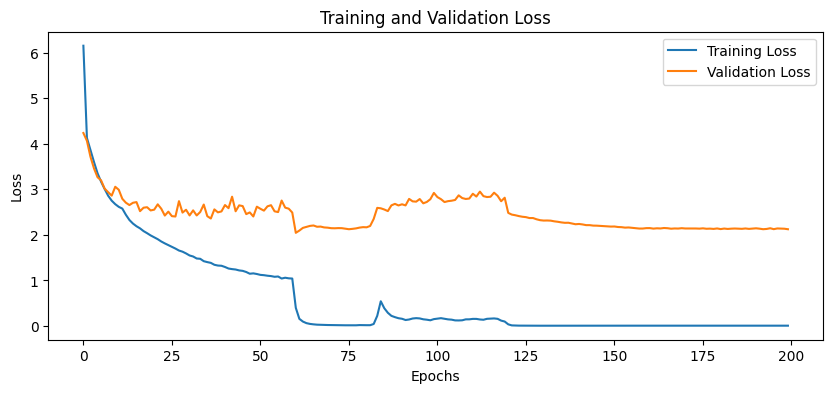



 Test set: Average loss: 2.1225, Accuracy: 5311/10000 (0.5311%), F1 Score: 0.5275


In [15]:
# torch.backends.cudnn.benchmark = True
# resnet50_cifr10 = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
# resnet50_cifr10.to(device)
# summary(resnet50_cifr10, (3, 32, 32))

# train_losses, val_losses = train_model(resnet50_cifr10, trainloader, validloader,
#                                        epochs=200, learning_rate=0.1, gamma_lr=0.2,
#                                        milestones=[60, 120,160], save_path='./resnet50_cifr10_new_arc2.pth', Weight_decay=5e-4)
# test_model(resnet50_cifr10, testloader , load_path="./resnet50_cifr10_new_arc2.pth")


resnet50_cifr100 = ResNet(Bottleneck, [3, 4, 6, 3])
resnet50_cifr100.to(device)
summary(resnet50_cifr100, (3, 32, 32))


train_losses, val_losses = train_model(resnet50_cifr100, trainloader100, validloader100,
                                       epochs=200, learning_rate=0.1, gamma_lr=0.2,
                                       milestones=[60, 120,160], save_path='./resnet50_cifr100_new_arc2.pth', Weight_decay=5e-4)


test_model(resnet50_cifr100, testloader100 , load_path="./resnet50_cifr100_new_arc2.pth")